In [13]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
import getdist
import arviz as az
import coplot.plot_contours as plc
import matplotlib.pyplot as plt
import random
import tensorflow_addons as tfa
import warnings
warnings.filterwarnings('ignore')

In [19]:
#Datos de planck
planck_samples = getdist.loadMCSamples(r'Planck_Data\COM_CosmoParams_fullGrid_R3.01\base_omegak\plikHM_TTTEEE_lowl_lowE_BAO\base_omegak_plikHM_TTTEEE_lowl_lowE_BAO', settings={'ignore_rows':0.3})
planck = planck_samples.getParams()

In [14]:
#Mediciones de Hz
z_o = [0.07, 0.09, 0.12, 0.17, 0.1791, 
     0.1993, 0.2, 0.24, 0.27, 0.28, 
     0.30, 0.31, 0.34, 0.35, 0.3519,
     0.36, 0.38, 0.3802, 0.4, 
     0.4004, 0.4247, 0.43, 0.44, 0.4497,
     0.47, 0.4783, 0.48, 0.51,
     0.52, 0.56, 0.57, 0.59, 0.5929,
     0.6, 0.61, 0.64, 0.6797, 0.73,
     0.7812, 0.8754, 0.88, 0.9, 1.037,
     1.3, 1.363, 1.43, 1.53, 1.75,
     1.965, 2.3, 2.33, 2.34, 2.36]

H_o = [69, 69, 68.6, 83, 75,
     75, 72.9, 79.69, 77, 88.8,
     81.7, 78.18, 83.8, 82.7,
     83, 79.94, 81.5, 83, 82.04,
     77, 87.1, 86.45, 84.81, 92.8,
     89, 80.9, 87.79, 90.4, 94.35,
     93.34, 96.8, 98.48, 104, 87.9,
     97.3, 98.82, 92, 97.3, 105,
     125, 90, 117, 154, 168,
     160, 177, 140, 202, 186.5,
     224, 224, 222, 226]

sigma_o = [19.6, 12, 26.2, 8, 4,
         5, 29.6, 2.99, 14, 36.64,
         6.22, 4.74, 3.66, 8.4, 14,
         3.38, 1.9, 13.5, 2.03, 10.2,
         11.2, 3.97, 1.83, 12.9, 34,
         9, 2.03, 1.9, 2.64, 2.3,
         3.4, 3.18, 13, 6.1, 2.1,
         2.98, 8, 7, 12, 17,
         40, 23, 20, 17, 33.6,
         18, 14, 40, 50.4, 8,
         8, 7, 8]

h_o = [val/100 for val in H_o]

Estimamos primero los parámetros con el algoritmo de Metropolis-Hastings para comparar con los futuros resultados de las redes neuronales

In [18]:
#Metropolis Hastings

def Hz_2(z, H0, omega_m, omega_l):
    omega_k = 1 - omega_m - omega_l
    result = H0**2 * (omega_m*(1+z)**3 + omega_l + omega_k*(1+z)**2)
    return result

def log_prob(H0, omega_m, omega_l, exclude):
    obs_data = zip(z_o[:exclude], H_o[:exclude], sigma_o[:exclude])
    result = 0
    omega_k = 1 - omega_m - omega_l
    if(H0 < 50 or H0 > 100 or omega_m < 0 or omega_m > 1 or omega_l < 0 or omega_l > 1):
        return -np.inf
    if(omega_k <-0.1 or omega_k > 0.1 ):
        return -np.inf
    for z, H, s in obs_data:
        calculated_H = Hz_2(z, H0, omega_m, omega_l)
        result += -0.5*((H**2 - calculated_H)/(2*H*s))**2
    return result

def Metropolis_Hasting(N, burnin,init_H0, init_omegam, init_omegal, std_H0, std_omegam, std_omegal, exclude = None):
    
    H0 = init_H0
    omegam = init_omegam
    omegal = init_omegal
    
    sampling = []
    acceptance_rate = 0


    for i in range(N):
        next_H0 = np.random.normal(H0,std_H0)
        next_omegam = np.random.normal(omegam,std_omegam)
        next_omegal = np.random.normal(omegal,std_omegal)
    
        r = min(0, log_prob(next_H0, next_omegam,next_omegal,exclude) - log_prob(H0, omegam, omegal, exclude))
        u = np.random.uniform(0,1)
        if(np.log(u) < r):
            H0, omegam, omegal = next_H0, next_omegam,next_omegal
            acceptance_rate += 1
        sampling.append((H0, omegam, omegal))

    acceptance_rate /= N
    
    return sampling[burnin:] , acceptance_rate

#Valores iniciales
init_H0 = 65
init_omegam = 0.3
init_omegal = 0.7
std_H0 = 0.8
std_omegam = 0.025
std_omegal = 0.025

N = 35000
burnin = 5000

result_sampling, acceptance_rate = Metropolis_Hasting(N, burnin,
                                                      init_H0, init_omegam, init_omegal, 
                                                      std_H0, std_omegam, std_omegal, exclude = None)


print(np.mean(result_sampling, axis=0))
print(acceptance_rate)

MH_H_0, MH_omega_m, MH_omega_l = zip(*result_sampling)

[69.42920596  0.25834945  0.70777938]
0.25042857142857144


Pasamos ahora a estimar usando redes neuronales

In [15]:
#Creador de datos artificiales

def Hz2_calculator(z_values,sigma_values, h0, om, ol):
    result_Hz = []
    for i in range(len(z_o)):
        z = z_values[i]
        s = sigma_values[i]
        h = h0**2*(om*(1+ z)**3 + ol + (1-om-ol)*(1 + z)**2)
        h += random.gauss(0,2*h_o[i]*s/100)
        #h += random.gauss(0,(s/100)**2)
        result_Hz.append(h)
    return np.array(result_Hz)
        
    
def Hz_data_creator(z,sigma,n,h0_bound, omh_bound, olh_bound):
    sim_Hz = []
    sim_params = []
    for i in range(n):
        while True:
            sim_om = random.uniform(omh_bound[0],omh_bound[1])
            sim_ol = random.uniform(olh_bound[0],olh_bound[1])
            sim_h0 = random.uniform(h0_bound[0],h0_bound[1])
            k = 1 - sim_om - sim_ol
            if(abs(k)<0.1):
                break
        sim_Hz.append(Hz2_calculator(z,sigma,sim_h0,  sim_om, sim_ol))
        sim_params.append(np.array([sim_h0, sim_om, sim_ol]))
    return sim_Hz, sim_params

In [16]:
#Modelo de red neuronal densa
def create_foward_model(hidden_units):
    input_layer = Input(shape=(len(z_o),))
    features = layers.BatchNormalization()(input_layer)
    
    features = layers.Dense(128, activation=tfa.activations.rrelu)(features)
    features = layers.BatchNormalization()(features)
    features = layers.Dense(10, activation=tfa.activations.rrelu)(features)
 
    outputs = layers.Dense(units=3)(features)

    model = keras.Model(inputs=input_layer, outputs=outputs)
    return model

#Obtencion de predicciones de la red
def get_results_foward(model, n):
    n_predict = n
    h_o_p = []
    for k in range(round(n_predict)):
        temp_h_o = []
        for i in range(len(z_o)):
            temp_h_o.append(random.gauss(h_o[i], sigma_o[i]/100)**2)
        h_o_p.append(temp_h_o)
    prediction = model(np.array(h_o_p)).numpy()

    return prediction

In [21]:
#Entrenamiento de 10 redes neutonales

num_nets = 10
pred_array = []
for l in range(num_nets):
    learning_rate = 0.01
    n = 5000
    num_epochs = 50
    n_steps = 3 #Iteraremos 3 vesces el algoritmo
    nodes = [128,10]
    bounds = [[0.3,1], [0,1], [0, 1]] #Intervalos donde buscar los parametros
    batch_size = 512
    
    foward_model = create_foward_model(nodes)
    foward_model.compile(
        optimizer = tf.optimizers.Adam(learning_rate=learning_rate),
        loss = tf.keras.losses.MeanAbsoluteError(),
        metrics=[keras.metrics.RootMeanSquaredError()],
    )

    print("Start training net number ", l+1)
    for i in range(n_steps):
    
        mock_Hz, mock_params = Hz_data_creator(z_o,sigma_o,n, bounds[0], bounds[1], bounds[2])
        X_train, X_test, y_train, y_test = train_test_split(np.array(mock_Hz), np.array(mock_params), test_size=0.10, random_state=40)

    
        foward_model.fit(X_train, y_train, epochs=num_epochs, validation_data = (X_test, y_test), verbose = 0, batch_size = batch_size)

    
        print("--------------------------------------")
        print("STEP "+ str(i+1)+ " predicted intervals:")
        prediction = get_results_foward(foward_model, n)
        interval = az.hdi(prediction,hdi_prob=0.999999)
        bounds = [[max(interval[0][0], 0), min(interval[0][1], 1)],
              [max(interval[1][0], 0), min(interval[1][1], 1)],
              [max(interval[2][0], 0), min(interval[2][1], 1)]]
        
        for b in bounds:
            print(b)
            
    pred_array.append(prediction)
    
final_pred = np.array(pred_array)
final_pred.shape = (final_pred.shape[0]*final_pred.shape[1], final_pred.shape[2])


Start training net number  1
--------------------------------------
STEP 1 predicted intervals:
[0.6479064226150513, 0.7387863397598267]
[0.2188785970211029, 0.3737752437591553]
[0.5987670421600342, 0.7639748454093933]
--------------------------------------
STEP 2 predicted intervals:
[0.6628261804580688, 0.7165210247039795]
[0.22583548724651337, 0.3201305866241455]
[0.6211531758308411, 0.7815285921096802]
--------------------------------------
STEP 3 predicted intervals:
[0.6702956557273865, 0.7236849665641785]
[0.2113172709941864, 0.3041980564594269]
[0.6233581304550171, 0.791728138923645]
Start training net number  2
--------------------------------------
STEP 1 predicted intervals:
[0.6678459644317627, 0.7553638815879822]
[0.26362159848213196, 0.37071284651756287]
[0.5996623039245605, 0.7201080322265625]
--------------------------------------
STEP 2 predicted intervals:
[0.6724342107772827, 0.7072744965553284]
[0.24956631660461426, 0.32695844769477844]
[0.6325082778930664, 0.710953

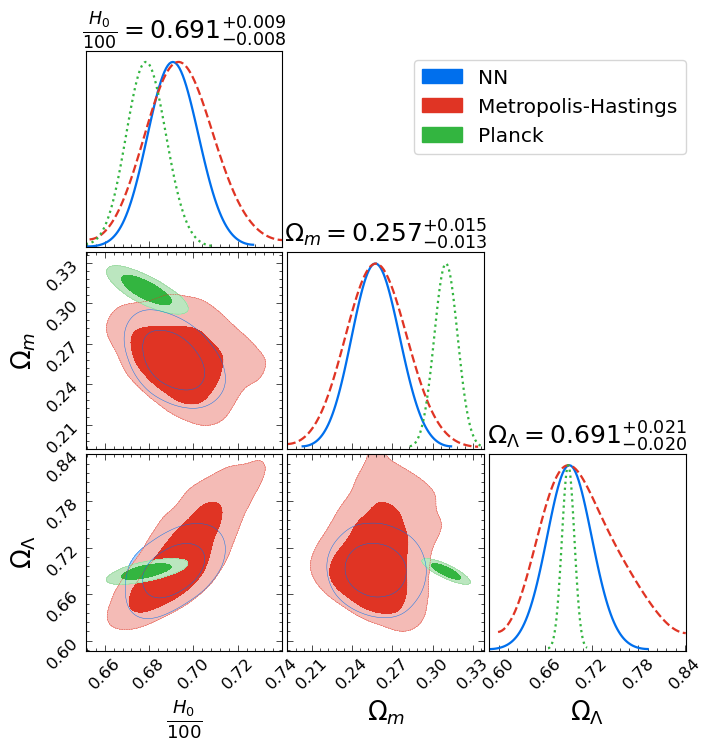

In [22]:
#Grafica de la distribucion de las estimaciones
MH = np.stack((np.array(MH_H_0)/100, MH_omega_m, MH_omega_l), axis=1)
Planck = np.stack((planck.H0/100, planck.omegam, planck.omegal), axis=1)

fig = plc.Contours([final_pred,MH,Planck]).plot(labels=[r"$\frac{H_0}{100}$", r"$\Omega_m$", r"$\Omega_\Lambda$"],
                               legend=True, legend_labels=['NN','Metropolis-Hastings','Planck'],subplots_adjust=True, smooth=10,
                              sigma = 2, show_titles=True)
plt.show()

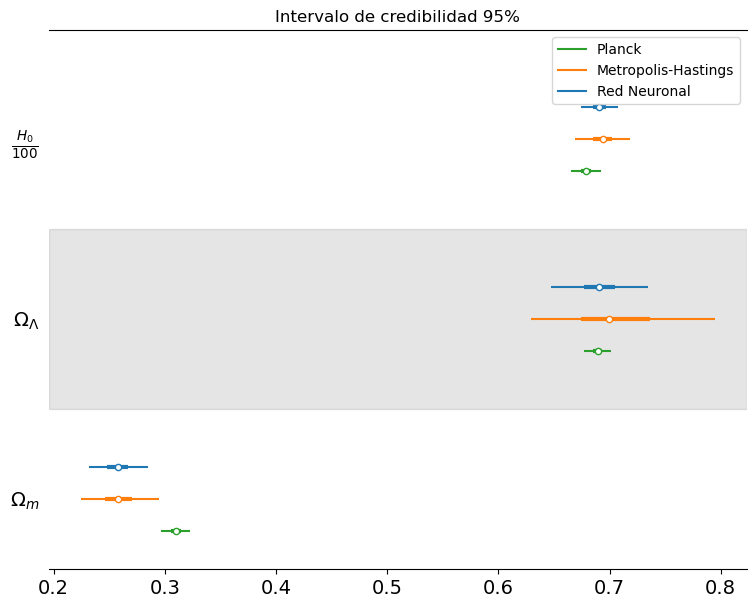

In [23]:
#Intervalos de credibilidad
MCMC = {r"$\Omega_m$": np.array(MH_omega_m),r"$\frac{H_0}{100}$": np.array(MH_H_0)/100, r"$\Omega_\Lambda$": np.array(MH_omega_l)}
Planck = {r"$\Omega_m$": planck.omegam, r"$\frac{H_0}{100}$": planck.H0/100,  r"$\Omega_\Lambda$": planck.omegal}
NN = {r"$\Omega_m$": final_pred[:,1],r"$\frac{H_0}{100}$": final_pred[:,0], r"$\Omega_\Lambda$": final_pred[:,2]}

axis = az.plot_forest([NN,MCMC, Planck],
                        model_names = ["Red Neuronal","Metropolis-Hastings", "Planck"],
                        kind='forestplot',
                        combined=True,
                        hdi_prob = 0.95 ,
                        figsize=(9, 7))
axis[0].set_title('Intervalo de credibilidad 95%')
plt.show()